In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


### Normal Traffic
We collect normal traffic from a simulated consumer IoT network over the course of 10 minutes. There are three devices: a security camera, a blood pressure monitor, and a smart outlet. There is also an Android phone to control these devices; the phone also serves as a wif link for uploading data to the internet, as is the case for the bluetooth-connected blood presure monitor.

In [2]:
normal = pd.read_csv('data/ddos/normal.csv')
normal['Label'] = 0 # 0 is normal traffic, 1 is attack traffic

In [3]:
# We split the traffic by device using the source IP of the three
# devices connected to wifi.

# WeMo Smart Switch: a Wifi connected outlet that is controlled
# by a phone via the cloud.
normal_switch = normal[normal['Source'] == '172.24.1.81']

# Yi Home Camera: a Wifi enabled home security camera that supports
# control and streaming from your phone via the cloud.
normal_camera = normal[normal['Source'] == '172.24.1.107']

# Android Phone. This phone, although not an IoT device, controls three
# diffferent IoT devices on the network:
# 1. WeMo Smart Switch: turns switch on/off
# 2. Yi Home Camera: live video streaming 
# 3. Withings Blood Pressure Monitor: connect to device via bluetooth and 
#    uploads medical data to cloud; the phone acts just as a wifi link
# Phones behave quite differently from other IoT devices. They connect with
# more endpoints and are more versatile in the types of protocols they use.
normal_phone = normal[normal['Source'] == '172.24.1.63']

### Attack Traffic
We simulate the three most common denial of service of attacks that an IoT device infected with the Mirai botnet
would execute. Using a Linux VM and a Raspberry Pi connected to a router running on another Raspberry Pi, we generates attack traffic across the three following attack vectors:
1. HTTP GET Flood - 2 miuntes; simulated with Goldeneye on Linux VM attacking Google.com
2. TCP SYN Flood - 5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN
3. UDP Flood - 2.5 minutes; simulated with hping3 on Raspberry Pi attacking Linux VM on LAN

We preprocess the attack traffic as if the attacks are coming from the devices in the simulated IoT network. We make a variety of assumptions in order to overlay the attack traffic on the three hosts from the normal traffic. Each of the three Wifi connected devices is infected with the botnet and will execute each of the four attacks once within a 10 minute internal in a random order for a random time period of around 100 seconds each; this way, at any given time, there is a 50% probability that an attack is underway ( (100*3)/600 = .5). During an attack period, each device will be able to simultaneously send attack and normal traffic. The distribution of attacks between devices is independent of each other. We set the target of all attacks to an arbitrary IP on the internet: 8.8.8.8. (e.g. google.com) at a fixed port (80 for http attack, 443 for tcp/udp attack). 

**Note: We assume that we cannot leverage the destination IP address for classification purposes because we do not want to maintain state at the router. This is a KEY advantage of using ML for flow-based anomaly detection. Otherwise, we could consume memory at the router and count the number of connections to each external IP address; if above threshold, we could identify DOS attack.

In [4]:
# Load attack traffic
attack_http = pd.read_csv('data/ddos/http_get_attack.csv')
attack_tcp = pd.read_csv('data/ddos/tcp_flood.csv')
attack_udp = pd.read_csv('data/ddos/udp_flood.csv')

# Add Label, 0 is normal traffic, 1 is attack traffic
attack_http['Label'] = 1
attack_tcp['Label'] = 1
attack_udp['Label'] = 1

# clean the attack data by isolating the source IP address
# only consider look at DOS attack originating from within the network.
attack_http = attack_http[ (attack_http['Source'] == '172.24.1.67') & (attack_http['Destination'] == '172.217.11.36')]
attack_tcp = attack_tcp[ (attack_tcp['Source'] == '172.24.1.108') & (attack_tcp['Destination'] == '172.24.1.67') ]
attack_udp = attack_udp[ (attack_udp['Source'] == '172.24.1.108') & (attack_udp['Destination'] == '172.24.1.67') ]

# set destination IP of attacks
attack_http['Destination'] = '8.8.8.8'
attack_tcp['Destination'] = '8.8.8.8'
attack_udp['Destination'] = '8.8.8.8'

# set destination ports of attacks
attack_http['Dst_port'] = 80
attack_tcp['Dst_port'] = 443
attack_udp['Dst_port'] = 443

In [5]:
attack_tcp.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label
1,2,0.017480,172.24.1.108,8.8.8.8,SSH,122,Server: Encrypted packet (len=56),22.0,443,0.017480,1
4,5,0.031885,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.001397,1
13,14,0.737961,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.027162,1
15,16,0.738272,172.24.1.108,8.8.8.8,TCP,66,22 > 50953 [ACK] Seq=137 Ack=201 Win=294 Len=0...,22.0,443,0.000089,1
16,17,0.738418,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000146,1
17,18,0.738984,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000566,1
21,22,0.839763,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.040248,1
24,25,0.942004,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.058905,1
27,28,0.962898,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.000095,1
31,32,1.143729,172.24.1.108,8.8.8.8,SSH,106,Server: Encrypted packet (len=40),22.0,443,0.009299,1


#### Device 1 (WeMo Smart Switch) Attack Profile  
Attack 1: HTTP GET Flood, 90 seconds, 20-110 sec  
Attack 2: TCP SYN Flood, 110 seconds, 300-410 sec  
Attack 3: UDP Flood, 100 seconds, 475-575 sec  

In [10]:
# attack 1
attack_http_switch = attack_http[attack_http['Time'] <= 90]
attack_http_switch.loc[:,'Time'] = attack_http_switch['Time'] + 20
attack_http_switch.loc[:,'Source'] = '172.24.1.81'

# attack 2
attack_tcp_switch = attack_tcp[attack_tcp['Time'] <= 110]
attack_tcp_switch.loc[:,'Time'] = attack_tcp_switch['Time'] + 300
attack_tcp_switch.loc[:,'Source'] = '172.24.1.81'

# attack 3
attack_udp_switch = attack_udp[attack_udp['Time'] <= 100]
attack_udp_switch.loc[:,'Time'] = attack_udp_switch['Time'] + 475
attack_udp_switch.loc[:,'Source'] = '172.24.1.81'

#### Device 2 (YI Home Camera) Attack Profile  
Attack 1: TCP SYN Flood, 80 seconds, 25-107 sec  
Attack 2: HTTP GET Flood, 100 seconds, 310-410 sec  
Attack 3: UDP Flood, 120 seconds, 450-570 sec  

In [11]:
# attack 1
attack_tcp_camera = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_camera.loc[:,'Time'] = attack_tcp_camera['Time'] + 25
attack_tcp_camera.loc[:,'Source'] = '172.24.1.107'

# attack 2
attack_http_camera = attack_http[attack_http['Time'] <= 100]
attack_http_camera.loc[:,'Time'] = attack_http_camera['Time'] + 310
attack_http_camera.loc[:,'Source'] = '172.24.1.107'

# attack 3
attack_udp_camera = attack_udp[attack_udp['Time'] <= 120]
attack_udp_camera.loc[:,'Time'] = attack_udp_camera['Time'] + 450
attack_udp_camera.loc[:,'Source'] = '172.24.1.107'

#### Device 3 (Android Phone) Attack Profile  
Attack 1: UDP Flood, 105 seconds, 5-120 sec  
Attack 2: TCP SYN Flood, 80 seconds, 240-320 sec  
Attack 3: HTPP GET Flood, 115 seconds, 420-535 sec  

In [12]:
# attack 1
attack_udp_phone = attack_udp[attack_udp['Time'] <= 105]
attack_udp_phone.loc[:,'Time'] = attack_udp_phone['Time'] + 5
attack_udp_phone.loc[:,'Source'] = '172.24.1.63'

# attack 2
attack_tcp_phone = attack_tcp[attack_tcp['Time'] <= 80]
attack_tcp_phone.loc[:,'Time'] = attack_tcp_phone['Time'] + 240
attack_tcp_phone.loc[:,'Source'] = '172.24.1.63'

# attack 3
attack_http_phone = attack_http[attack_http['Time'] <= 115]
attack_http_phone.loc[:,'Time'] = attack_http_phone['Time'] + 420
attack_http_phone.loc[:,'Source'] = '172.24.1.63'

### Generating features and labels (1=attack, 0=normal) for each device
**Note: Our approach assumes a constant set of features that is not protocol specific. This adds to the versatility of our proposed methodology.

#### WeMo Switch Feature Generation

In [13]:
# merge attack and normal traffic
switch_data = pd.concat([normal_switch, attack_http_switch, attack_tcp_switch, attack_udp_switch])
camera_data = pd.concat([normal_camera, attack_http_camera, attack_tcp_camera, attack_udp_camera])
phone_data = pd.concat([normal_phone, attack_http_phone, attack_tcp_phone, attack_udp_phone])

In [14]:
# generate device specific temporal features
def generate_device_temporal_features_and_labels(data):
    # map each row to a 10 second time bin
    data['TimeBin'] = data['Time']
    data['TimeBin'] = (data['TimeBin']/10.0)
    data['TimeBin'] = data['TimeBin'].apply(np.floor)
    group = data.groupby(['TimeBin'])
    group_features = group.apply(group_feature_extractor)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_num_dest'].diff(periods=1)
    group_features['device_timebin_delta_num_dest'] = group_features['device_timebin_delta_num_dest'].fillna(0)

    data = data.merge(group_features, left_on='TimeBin', right_index=True)
    return data
    
def group_feature_extractor(g):
    ten_sec_traffic = (g['Length']).sum() / 10
    ten_sec_num_host = len(set(g['Destination']))
    return pd.Series([ten_sec_traffic, ten_sec_num_host], index = ['device_timebin_bandwidth', 'device_timebin_num_dest'])

In [15]:
switch_data = generate_device_temporal_features_and_labels(switch_data)
camera_data = generate_device_temporal_features_and_labels(camera_data)
phone_data = generate_device_temporal_features_and_labels(phone_data)

In [16]:
switch_data

,No.,Time,Source,Destination,Protocol,Length,Info,Src_port,Dst_port,Delta_time,Label,TimeBin,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest
83,84,18.604856,172.24.1.81,172.24.1.1,ICMP,98,"Echo (ping) request id=0x7b08, seq=0/0, ttl=6...",NaN,NaN,1.916105,0,1.0,8888.0,2.0,0.0
85,86,18.683087,172.24.1.81,172.24.1.1,DNS,76,Standard query 0x001d A insight.lswf.net,3076.0,53.0,0.078088,0,1.0,8888.0,2.0,0.0
87,88,18.695402,172.24.1.81,23.21.145.73,TCP,66,4925 > 443 [SYN] Seq=0 Win=5840 Len=0 MSS=1460...,4925.0,443.0,0.002567,0,1.0,8888.0,2.0,0.0
89,90,18.704376,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=1 Ack=1 Win=5840 Len=0,4925.0,443.0,0.001640,0,1.0,8888.0,2.0,0.0
90,91,18.740927,172.24.1.81,23.21.145.73,TLSv1,175,Client Hello,4925.0,443.0,0.036551,0,1.0,8888.0,2.0,0.0
95,96,18.751015,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=1461 Win=8760 Len=0,4925.0,443.0,0.001637,0,1.0,8888.0,2.0,0.0
97,98,18.752558,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=2921 Win=11680 Len=0,4925.0,443.0,0.000980,0,1.0,8888.0,2.0,0.0
98,99,18.752695,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=4097 Win=14600 Len=0,4925.0,443.0,0.000137,0,1.0,8888.0,2.0,0.0
99,100,18.753909,172.24.1.81,23.21.145.73,TCP,54,4925 > 443 [ACK] Seq=122 Ack=5514 Win=17520 Len=0,4925.0,443.0,0.001214,0,1.0,8888.0,2.0,0.0
100,101,19.092679,172.24.1.81,23.21.145.73,TLSv1,252,"Client Key Exchange, Change Cipher Spec, Encry...",4925.0,443.0,0.338770,0,1.0,8888.0,2.0,0.0


In [17]:
def generate_features_and_labels(data):
    data.sort_values(by=['Time'],  ascending=[1]) # sort all traffic by time
    data = data.dropna() # drop rows with either missing source or destination ports
    data = data.reset_index(drop=True)
    
    # GENERATE FEATURES
    features = data.copy(deep=True)

    # velocity, acceleration, and jerk in time in between successive packets
    features['dT'] = features['Time'] - features['Time'].shift(3)
    features['dT2'] = features['dT'] - features['dT'].shift(3)
    features['dT3'] = features['dT2'] - features['dT2'].shift(3)
    features = features.fillna(0) # fill offset rows with zeros #### FIX THIS - not working...

    # one hot encoding of common protocols: HTTP: TCP, UDP, and OTHER
    features['is_HTTP'] = 0
    features.loc[ ( (features['Protocol'] == 'HTTP') | (features['Protocol'] == 'HTTP/XML') ), ['is_HTTP']] = 1

    features['is_TCP'] = 0
    features.loc[features['Protocol'] == 'TCP', ['is_TCP']] = 1

    features['is_UDP'] = 0
    features.loc[features['Protocol'] == 'UDP', ['is_UDP']] = 1

    features['is_OTHER'] = 0
    features.loc[(
                    (features['Protocol'] != 'HTTP') &
                    (features['Protocol'] != 'HTTP/XML') &
                    (features['Protocol'] != 'TCP') &
                    (features['Protocol'] != 'UDP') 
                ), ['is_OTHER']] = 1

    # generate time-series features based on last most recent 10,000 packets:
    # 1. percent of traffic to the given destination IP
    # 2. percent of traffic to the given destination port
    # 3. Devices 
    # TODO
    
    # GENERATE LABELS
    labels = features['Label']

    del features['No.']
    del features['Time']
    del features['Source']
    del features['Destination']
    del features['Protocol']
    del features['Info']
    del features['Src_port']
    del features['Dst_port']
    del features['Delta_time']
    del features['Label']
    del features['TimeBin']
    
    return (features, labels)

In [18]:
# generate 
switch_features, switch_labels = generate_features_and_labels(switch_data)
camera_features, camera_labels = generate_features_and_labels(camera_data)
phone_features, phone_labels = generate_features_and_labels(phone_data)

In [19]:
all_features = pd.concat([switch_features, camera_features, phone_features])
all_labels = pd.concat([switch_labels, camera_labels, phone_labels])

### Normalize Data

In [20]:
# rescale numerical columns to standard normal
numerical = all_features.iloc[:, [0,1,2,3,4,5,6]]
numerical = (numerical - np.mean(numerical, axis=0)) / np.std(numerical, axis=0)
# rescale categorical columns from [0,1] to [-1,1]
categorical = all_features.iloc[:, [7,8,9,10]]
categorical = categorical*2-1
# recombine data
all_features = pd.concat([numerical, categorical], axis=1)

In [21]:
all_features

,Length,device_timebin_bandwidth,device_timebin_num_dest,device_timebin_delta_num_dest,dT,dT2,dT3,is_HTTP,is_TCP,is_UDP,is_OTHER
0,-0.081194,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,-1,-1,1
1,-0.139957,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,1,-1,-1
2,-0.210472,-1.208889,-0.498237,-0.059281,-0.002757,0.000016,-0.000009,-1,1,-1,-1
3,0.500557,-1.208889,-0.498237,-0.059281,0.026265,0.000016,-0.000009,-1,-1,-1,1
4,-0.210472,-1.208889,-0.498237,-0.059281,0.025148,0.000016,-0.000009,-1,1,-1,-1
5,-0.210472,-1.208889,-0.498237,-0.059281,0.021419,0.000016,-0.000009,-1,1,-1,-1
6,-0.210472,-1.208889,-0.498237,-0.059281,0.003148,-0.016468,-0.000009,-1,1,-1,-1
7,-0.210472,-1.208889,-0.498237,-0.059281,-0.001304,-0.018846,-0.000009,-1,1,-1,-1
8,0.953029,-1.208889,-0.498237,-0.059281,0.167904,0.104470,-0.000009,-1,-1,-1,1
9,-0.210472,-1.208889,-0.498237,-0.059281,0.172555,0.120815,0.079471,-1,1,-1,-1


In [22]:
# get subset of features (non-temporal)
packet_features = all_features.iloc[:,[0,4,5,6,7,8,9,10]]

In [23]:
packet_features

,Length,dT,dT2,dT3,is_HTTP,is_TCP,is_UDP,is_OTHER
0,-0.081194,-0.002757,0.000016,-0.000009,-1,-1,-1,1
1,-0.139957,-0.002757,0.000016,-0.000009,-1,1,-1,-1
2,-0.210472,-0.002757,0.000016,-0.000009,-1,1,-1,-1
3,0.500557,0.026265,0.000016,-0.000009,-1,-1,-1,1
4,-0.210472,0.025148,0.000016,-0.000009,-1,1,-1,-1
5,-0.210472,0.021419,0.000016,-0.000009,-1,1,-1,-1
6,-0.210472,0.003148,-0.016468,-0.000009,-1,1,-1,-1
7,-0.210472,-0.001304,-0.018846,-0.000009,-1,1,-1,-1
8,0.953029,0.167904,0.104470,-0.000009,-1,-1,-1,1
9,-0.210472,0.172555,0.120815,0.079471,-1,1,-1,-1


### Train and Test Neural Net

In [24]:
def train_test(data, labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)   

    model = Sequential()
    model.add(Dense(11, activation='relu', input_dim=data.shape[1]))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=32)
    y_predict = np.round(model.predict(x_test, batch_size=128))
    
    # Analyze
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict)
    error = zero_one_loss(y_test, y_predict,)
    accuracy = 1 - error

    print("Normal Precision: " + str(precision[0]))
    print("Attack Precision: " + str(precision[1]))
    print("Normal Recall: " + str(recall[0])) 
    print("Attack Recall: " + str(recall[1])) 
    print("Normal F1: " + str(f1[0]))
    print("Attack F1: " + str(f1[1]))
    print("Error " + str(error))
    print("Accuracy " + str(accuracy))

    # confusion matrix    
    plt.figure()
    classes = ['Normal', 'Attack']
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
train_test(all_features.values, all_labels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100


In [1]:
train_test(packet_features.as_matrix(), all_labels)

NameError: name 'train_test' is not defined

### Train and Test General ML Techniques

In [0]:
# To validate our data, we split the samples into 10 folds, a standard practice for binary classification tasks.
# To get a general sense of how each of the classifiers perform, we iteratively train on 9 of the folds (after 
# finetuning) and test on the one fold that is withheld. We average the performance across the 10 tests to compensate
# for the possibility of overfitting when evaluating our classifiers. 

# sigmoid function for normalizing values between 0 and 1
def sig(x):
    return 1/(1+np.exp(-x))

# classifies the model on training data and returns zero-one loss on test data
def classify(model, x_train, x_test, y_train, y_test):
    classifier = model
    if classifier.__class__.__name__ == "MultinomialNB":
        classifier.fit(sig(x_train),y_train)
    else:
        classifier.fit(x_train,y_train)
    y_predict = classifier.predict(x_test)
    
    # ANALYSIS: 
    print("==================================")
    print(classifier.__class__.__name__ + ":")
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict)
    error = zero_one_loss(y_test, y_predict,)
    accuracy = 1 - error
    
    print("Normal Precision: " + str(precision[0]))
    print("Attack Precision: " + str(precision[1]))
    print("Normal Recall: " + str(recall[0])) 
    print("Attack Recall: " + str(recall[1])) 
    print("Normal F1: " + str(f1[0]))
    print("Attack F1: " + str(f1[1]))
    print("Error " + str(error))
    print("Accuracy " + str(accuracy))
    
    # confusion matrix    
    plt.figure()
    classes = ['Normal', 'Attack']
    cm = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # print feature importance
    if classifier.__class__.__name__ == "RandomForestClassifier":
        print("feature importance:" )
        feature_names = ["Length", "dT", "dT2", "dT3", "is_HTTP", "is_TCP", "is_UDP", "is_OTHER"]
        feat_imp = dict(zip(feature_names, classifier.feature_importances_))
        for feature in sorted(feat_imp.items(), key=lambda x: x[1], reverse=True):
            print(feature)
    
def run_classification(data, labels): 
    model_error = [0, 0, 0, 0, 0]
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)    

    # Evaluate five standard classifiers. 
    classify(KNeighborsClassifier(), x_train, x_test, y_train, y_test)
    classify(LinearSVC(), x_train, x_test, y_train, y_test)
    classify(DecisionTreeClassifier(), x_train, x_test, y_train, y_test)
    classify(RandomForestClassifier(), x_train, x_test, y_train, y_test)
    
    print("*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)")

KNeighborsClassifier:
Normal Precision: 0.997749130346
Attack Precision: 0.999506473901
Normal Recall: 0.993075356415
Attack Recall: 0.999840276467
Normal F1: 0.995406757171
Attack F1: 0.999673347319
Error 0.00060992965478
Accuracy 0.999390070345


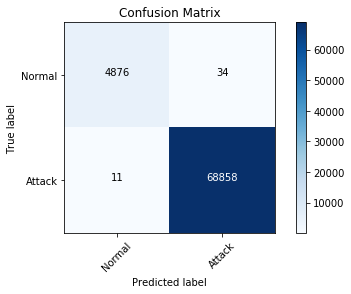

LinearSVC:
Normal Precision: 0.991873693987
Attack Precision: 0.990816444035
Normal Recall: 0.870061099796
Attack Recall: 0.999491788758
Normal F1: 0.926982749268
Attack F1: 0.995135209374
Error 0.00912183683704
Accuracy 0.990878163163


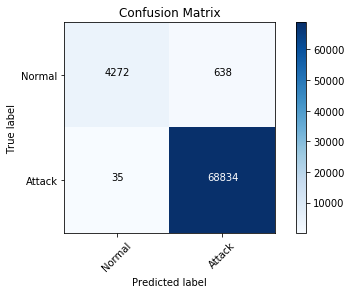

DecisionTreeClassifier:
Normal Precision: 0.995913363302
Attack Precision: 0.999477389853
Normal Recall: 0.99266802444
Attack Recall: 0.999709593576
Normal F1: 0.994288045696
Attack F1: 0.999593478229
Error 0.000759023570393
Accuracy 0.99924097643


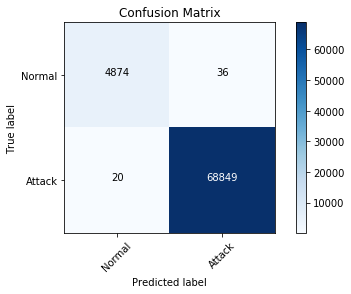

RandomForestClassifier:
Normal Precision: 0.998776508972
Attack Precision: 0.999825771325
Normal Recall: 0.997556008147
Attack Recall: 0.999912878073
Normal F1: 0.99816588547
Attack F1: 0.999869322802
Error 0.000243971861912
Accuracy 0.999756028138


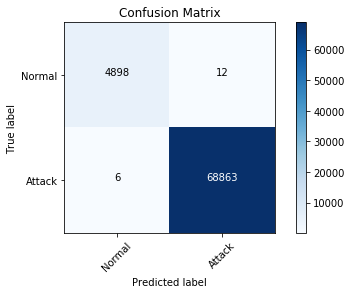

feature importance:
('Length', 0.51888324440617362)
('is_HTTP', 0.11061282483290194)
('is_UDP', 0.095053905879180237)
('dT', 0.081753040837416316)
('is_OTHER', 0.043888048763848449)
('is_TCP', 0.04201854276553664)
('dT2', 0.030446743116567032)
('dT3', 0.013987798488389977)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [0]:
run_classification(all_features.as_matrix(), all_labels)

KNeighborsClassifier:
Normal Precision: 0.980189491817
Attack Precision: 0.996745497939
Normal Recall: 0.95289930919
Attack Recall: 0.998666705313
Normal F1: 0.966351767328
Attack F1: 0.997705176745
Error 0.00429661556812
Accuracy 0.995703384432


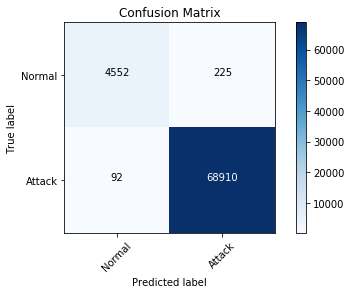

LinearSVC:
Normal Precision: 0.990683229814
Attack Precision: 0.990947365396
Normal Recall: 0.868118065732
Attack Recall: 0.999434798991
Normal F1: 0.925359812563
Attack F1: 0.995172986038
Error 0.00906762086773
Accuracy 0.990932379132


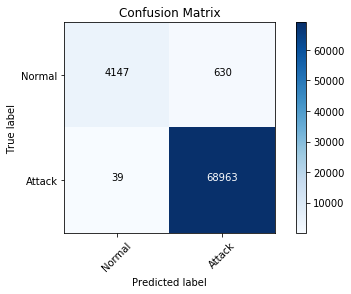

DecisionTreeClassifier:
Normal Precision: 0.995674740484
Attack Precision: 0.99749837322
Normal Recall: 0.963784802177
Attack Recall: 0.999710153329
Normal F1: 0.97947026912
Attack F1: 0.998603038572
Error 0.00261592051939
Accuracy 0.997384079481


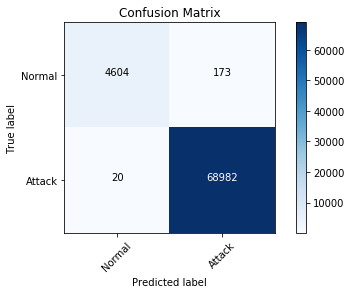

RandomForestClassifier:
Normal Precision: 0.997195253506
Attack Precision: 0.997758301516
Normal Recall: 0.967552857442
Attack Recall: 0.999811599664
Normal F1: 0.982150446239
Attack F1: 0.998783895299
Error 0.00227707071118
Accuracy 0.997722929289


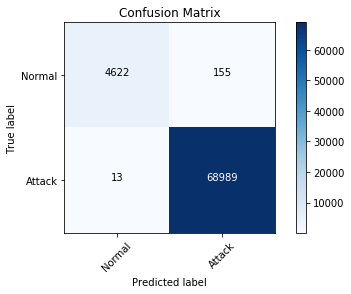

feature importance:
('Length', 0.53460639975205171)
('dT3', 0.14172561018165425)
('dT', 0.12211805725981281)
('dT2', 0.088595925502590836)
('is_UDP', 0.05962465904010221)
('is_HTTP', 0.039147731727020407)
('is_TCP', 0.012129767911965043)
('is_OTHER', 0.0020518486248027757)
*Note on evaluation metric: Error = 1 - Accuracy = 1 - (# correct classifications)/(# total classifications)


In [0]:
run_classification(packet_features.as_matrix(), all_labels)

In [0]:
all_labels.shape

(491855,)

In [0]:
all_labels[all_labels==1].shape

(459565,)

In [0]:
all_labels[all_labels==0].shape

(32290,)